# Distance workflow

In [22]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import geopandas as gpd
from tkinter import filedialog
from tkinter import Tk, filedialog
import tkinter as tk
import rasterio
from rasterio.features import rasterize
import os
from shapely.geometry import LineString


Requires a 2D numpy array with zeros and ones as input

In [2]:
def calculate_distance(arr, max_distance=20, dtype=np.float32):
    """
    Calculate normalized distance from 1's in the input array.

    Args:
    arr (np.ndarray): Input binary array.
    max_distance (float): Maximum distance to consider (default: 20).
    dtype (np.dtype): Data type for the output array (default: np.float32).

    Returns:
    np.ndarray: Normalized distance array.
    """
    # Ensure input is a numpy array
    arr = np.asarray(arr, dtype=bool)

    # Calculate the distance transform
    dist = distance_transform_edt(~arr)

    # Normalize the distance
    normalized_dist = np.clip(1 - dist / max_distance, 0, 1)

    return normalized_dist.astype(dtype)

In [ ]:
# Create an array with multiple points
arr = np.zeros((100, 200))
points = [
    (25, 50),
    (75, 150),
    (40, 100),
    (60, 30),
    (10, 180)
]

for point in points:
    arr[point] = 1

# Calculate the distance
result = calculate_distance(arr)

# Create figure with subfigures
fig = plt.figure(figsize=(8, 10))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1.1])  # Slightly more height for bottom plot to accommodate colorbar

# Top plot: Just the points
ax1 = subfigs[0].add_subplot(111)
im1 = ax1.imshow(arr, cmap='binary', aspect='equal')
ax1.set_title('Original Points')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

# Bottom plot: Distance calculation result
ax2 = subfigs[1].add_subplot(111)
im2 = ax2.imshow(result, cmap='viridis', aspect='equal')
ax2.set_title('Distance from Points')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')

# Add color bar to the second plot
# cbar = subfigs[1].colorbar(im2, ax=ax2, label='Normalized Distance')

# Add grid lines every 20 points for both plots
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0, 201, 20))
    ax.set_yticks(np.arange(0, 101, 20))
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)  # Ensure grid is behind the data

plt.tight_layout()
plt.show()

In [4]:
# Create an empty array
arr2 = np.zeros((100, 200), dtype=int)

# Add moderate-length lines
arr2[80, 20:40] = 1  # horizontal line, 20 pixels long
arr2[15, 140:165] = 1  # horizontal line, 25 pixels long
arr2[40:60, 70] = 1  # vertical line, 20 pixels long
arr2[25:45, 160] = 1  # vertical line, 20 pixels long
for i in range(15):
    arr2[85-i, 110+i] = 1  # diagonal line, about 21 pixels long

In [ ]:
# Calculate the distance
result = calculate_distance(arr2)

# Create figure with subfigures
fig = plt.figure(figsize=(12, 14))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1.1])

# Top plot: Points and lines
ax1 = subfigs[0].add_subplot(111)
im1 = ax1.imshow(arr, cmap='binary', aspect='equal')
ax1.set_title('Original Points and Lines')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

# Bottom plot: Distance calculation result
ax2 = subfigs[1].add_subplot(111)
im2 = ax2.imshow(result, cmap='viridis', aspect='equal')
ax2.set_title('Distance from Points and Lines')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')

# Add color bar to the second plot
#cbar = subfigs[1].colorbar(im2, ax=ax2, label='Normalized Distance')

# Add grid lines every 20 points for both plots
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0, 201, 20))
    ax.set_yticks(np.arange(0, 101, 20))
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)  # Ensure grid is behind the data

plt.tight_layout()
plt.show()

In [45]:
#DEFINE FUNCTIONS------------------------------------------- 

def calculate_distance(arr, max_distance=20, dtype=np.float32):
    """
    Calculate normalized distance from 1's in the input array.

    Args:
    arr (np.ndarray): Input binary array.
    max_distance (float): Maximum distance to consider (default: 20).
    dtype (np.dtype): Data type for the output array (default: np.float32).

    Returns:
    np.ndarray: Normalized distance array.
    """
    arr = np.asarray(arr, dtype=bool)

    # Calculate the distance transform
    dist = distance_transform_edt(~arr)

    # Normalize the distance
    normalized_dist = np.clip(1 - dist / max_distance, 0, 1)

    return normalized_dist.astype(dtype)

def create_gridded_distance_map(geojson_files, grid_size, max_distance=20):
    """
    Generate a 3D NumPy array with distance maps from line geometries in GeoJSON files.

    Args:
    geojson_files (list): List of file paths to GeoJSON files.
    grid_size (tuple): The size of the output grid (height, width).
    max_distance (float): Maximum distance for normalization.
    
    Returns:
    np.ndarray: 3D NumPy array with distance maps.
    """
    height, width = grid_size
    num_files = len(geojson_files)
    
    # Create an empty 3D array to store the distance layers
    distance_map = np.zeros((num_files, height, width), dtype=np.float32)
    
    for idx, geojson_file in enumerate(geojson_files):
        print(f"Processing {geojson_file}...")

        # Load the GeoJSON file
        gdf = gpd.read_file(geojson_file)

        # Create a binary grid of the line geometries
        transform = rasterio.transform.from_bounds(*gdf.total_bounds, width, height)
        shapes = []

        # Iterate through each geometry, ensuring it is not None
        for geom in gdf.geometry:
            if geom is None:
                continue  # Skip None geometries
            if geom.geom_type == 'LineString':
                shapes.append((geom, 1))
            elif geom.geom_type == 'MultiLineString':
                # Use .geoms to iterate over individual LineString components
                for line in geom.geoms:
                    if isinstance(line, LineString):
                        shapes.append((line, 1))
        
        # Rasterize the geometries to create the binary grid (dtype='uint8')
        if shapes:
            binary_grid = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype='uint8')
            
            # Calculate the distance map
            distance_map[idx] = calculate_distance(binary_grid, max_distance=max_distance)
        else:
            print(f"No valid line geometries found in {geojson_file}. Skipping...")

    return distance_map

# Function to interactively select files
def select_geojson_files():
    # Create a Tkinter root window (hidden)
    root = Tk()
    root.withdraw()  # Hide the main window
    root.attributes("-topmost", True)  # Bring the dialog to the front

    # Open the file selection dialog
    geojson_files = filedialog.askopenfilenames(
        title="Select GeoJSON Line Files",
        filetypes=[("GeoJSON files", "*.geojson"), ("All files", "*.*")]
    )
    
    root.destroy()  # Close the root window after selection
    return list(geojson_files)  # Convert tuple to list and return


In [46]:

# Example usage:
grid_size = (150, 100)  # Example grid size, replace this with your own variable
max_distance = 20

geojson_files = select_geojson_files()
if geojson_files:
    distance_map = create_gridded_distance_map(geojson_files, grid_size, max_distance=max_distance)

    # Now, `distance_map` contains the 3D array with distance maps
    print("Generated distance map shape:", distance_map.shape)
else:
    print("No files selected.")


Processing C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/MAP3_faults.geojson...
Generated distance map shape: (1, 150, 100)


In [47]:
# Load the GeoJSON file
gdf = gpd.read_file(geojson_files[0])

# Check the geometry types and bounds
print(f"Geometry types: {gdf.geometry.type.unique()}")
print(f"Total bounds of geometries: {gdf.total_bounds}")

# Ensure that the geometries are valid and within expected bounds
if not gdf.empty:
    print(f"Number of MultiLineString geometries: {len(gdf[gdf.geometry.type == 'MultiLineString'])}")

Geometry types: ['MultiLineString' None]
Total bounds of geometries: [-70.75213211 -31.2534934  -70.50211763 -31.00366087]
Number of MultiLineString geometries: 117


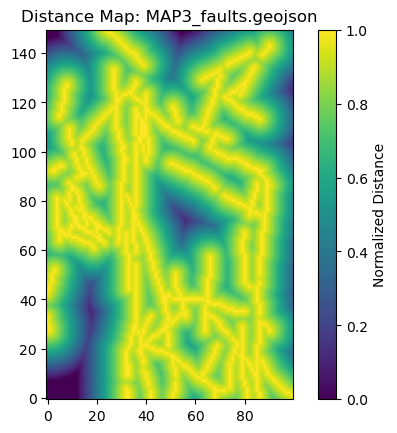

In [48]:
plt.imshow(distance_map[0], cmap='viridis', origin='lower')
plt.title(f"Distance Map: {os.path.basename(geojson_files[0])}")
plt.colorbar(label='Normalized Distance')
plt.show()